In [1]:
from header import *
plt.rcParams.update({'font.size': 16})
plots_dir = Path('imgs/')

In [4]:
def plot_scaling(df, x, y, prefix, hline=False, algo1=None, algo2=None, show_mean=False, trend_line=True, xlog=False, ylog=False):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F3F3F3')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['alg', x], group_keys=False, observed=True)[y].mean()  # observed=True drops categorical algos that don't appear
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='alg', values='mean_{}'.format(y))
   
    display(d)
    if trend_line:
        z = {}
        for algo in d.columns:
            s = d[algo].dropna()
            z[algo] = np.polyfit(s.index, np.log(s), 1)
        xs = list(d.index)
        if show_mean:
            d = d.append(df.groupby('alg')[y].mean().rename('all'))
        #xs.append(xs[-1]*1.1)  # extrapolation
        
        # ln(y[i]) ~= a*x[i] + b
        #  => y[i] ~= exp(a*x[i] + b)
        # y[i] = O(base^i) = C * base^i
        #  => a*x[i] + b = ln(C * base^x[i]) = ln(base)*x[i] + ln(C)
        #  => a*x[0] + b = ln(base)*x[0] + ln(C)
        #     a*x[1] + b = ln(base)*x[1] + ln(C)
        #  => a*(x[1]-x[0]) = ln(base)*(x[1]-x[0]) => base = exp(a)
        
        # Best fit lines
        for algo in d.columns:
            regression_line = []
            a, b = z[algo]
            #angle = math.atan2(a, abs(b)) * 180 / math.pi
            for i in xs:
                regression_line.append(np.exp(a*i+b))
            #display(regression_line)
            ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo), alpha=0.8)
            weight = 'bold' if 'seeds' in algo else 'normal'
            label = '$\sim {{{:0.2f}}}^x$'.format(np.exp(a*(s.index[1]-s.index[0])))
            ax.text(xs[-1], regression_line[-1], algo2beautiful(algo) + label,
                    color=algo2color(algo), ha='center', va='bottom', size=15, alpha=1, weight=weight)
    
    # ticks
    if x == 'error_rate':
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
    
    if x == 'cost':
        ax.set_xticks(np.arange(0, max(df[x])+1, 1))
    
    #arr = [ 0 ] + [ 10**n for n in range(0,int(math.log10(max(df[y])))+1) ]
    #ax.set_yticks(arr)

    # Times
    #for index, row in d.iterrows():
        #print(row["astar-seeds"])
        #print(row["astar-seeds-intervals"])
    #    label = '{0:.3g}x'.format(row[algo1] / row[algo2])
    #    tmp_x = index if index != 'all' else len(d)-1
    #    tmp_y = np.exp((np.log(row[0]) + np.log(row[1])) / 2)
    #    ax.text(tmp_x, tmp_y, label, ha='right', va='center', size=12, alpha=0.7)
        
    colors = [ algo2color(algo) for algo in d.columns ]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot(ax=ax, alpha=0.6, zorder=3, rot=0, color=colors, marker='o', ls='', legend=False)
    #d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    #if hline:
    #    ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 15}, framealpha=0.5)
    #else:
    #    ax.legend(loc="upper left", prop={'size': 15}, framealpha=0.5)

    if hline:
        if y == 'explored_states' or y == 'crumbs':
            miny = df.len.median()
            maxy = df.refsize.median()*df.len.median()
        elif y == 'explored_per_bp':
            miny = 1
            maxy = df.refsize.median()
        else:
            assert(False)
        
        ax.axhline(maxy, color='k', linestyle='--', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(0.0, maxy, 'max    ', ha='right', va='center', size=16)
        
        ax.axhline(y=miny, color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(0.0, miny, 'min    ', ha='right', va='center', size=16)

    if ylog:
        ax.set_yscale('log')
        
    if xlog:
        ax.set_xscale('log')
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labels
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

,alg,cnt,n,e,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,s_per_pair
0,pa,10000,100,0.01,1.3713,0:00:01,7.96,10.04,5.89,5.93,0.00,0.0,37.19,1.01,0.000137
1,edlib,10000,100,0.01,0.1317,0:00:00,4.64,7.41,1.80,2.00,0.00,0.0,0.00,0.00,0.000013
2,wfa,10000,100,0.01,0.2470,0:00:00,1.10,11.80,0.24,0.30,0.00,0.0,0.00,0.00,0.000025
3,pa,10000,100,0.05,1.3604,0:00:01,7.72,9.98,5.89,5.94,0.00,0.0,37.52,1.01,0.000136
4,edlib,10000,100,0.05,0.1298,0:00:00,4.31,7.29,1.55,1.74,0.00,0.0,0.00,0.00,0.000013
5,wfa,10000,100,0.05,0.2484,0:00:00,1.10,11.80,0.24,0.30,0.00,0.0,0.00,0.00,0.000025
6,pa,10000,100,0.20,1.4350,0:00:01,7.86,10.07,5.94,5.99,0.00,0.0,35.54,1.02,0.000144
7,edlib,10000,100,0.20,0.1359,0:00:00,6.01,8.99,2.93,3.12,0.00,0.0,0.00,0.00,0.000014
8,wfa,10000,100,0.20,0.2347,0:00:00,0.97,11.80,0.24,0.30,0.00,0.0,0.00,0.00,0.000023
9,pa,1000,1000,0.01,1.6444,0:00:01,7.73,9.84,5.90,5.94,0.00,0.0,61.41,1.51,0.001644


,alg,cnt,n,e,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,s_per_pair
6,pa,10000,100,0.2,1.4350,0:00:01,7.86,10.07,5.94,5.99,0.00,0.0,35.54,1.02,0.000144
7,edlib,10000,100,0.2,0.1359,0:00:00,6.01,8.99,2.93,3.12,0.00,0.0,0.00,0.00,0.000014
8,wfa,10000,100,0.2,0.2347,0:00:00,0.97,11.80,0.24,0.30,0.00,0.0,0.00,0.00,0.000023
15,pa,1000,1000,0.2,1.5750,0:00:01,9.62,11.30,7.52,7.57,0.00,0.0,64.14,1.52,0.001575
16,edlib,1000,1000,0.2,0.1426,0:00:00,5.44,8.18,2.56,2.75,0.00,0.0,0.00,0.00,0.000143
17,wfa,1000,1000,0.2,1.8212,0:00:01,5.74,11.80,4.17,4.23,0.00,0.0,55.45,1.51,0.001821
24,pa,100,10000,0.2,2.8833,0:00:02,50.56,52.56,48.62,48.67,0.00,0.0,70.06,2.52,0.028833
25,edlib,100,10000,0.2,0.5479,0:00:00,5.35,7.88,2.52,2.71,0.00,0.0,0.00,0.49,0.005479
26,wfa,100,10000,0.2,17.9659,0:00:17,393.12,399.69,391.55,391.61,0.00,0.0,82.32,15.29,0.179659
33,pa,10,100000,0.2,10.6400,0:00:10,1357.12,1359.06,1355.14,1355.18,0.00,0.0,92.39,10.32,1.064000


alg,edlib,pa,wfa
n,,,
100,0.000014,0.000144,0.000023
1000,0.000143,0.001575,0.001821
10000,0.005479,0.028833,0.179659
100000,0.192120,1.064000,19.404670
1000000,22.186800,104.216000,53.310300


n
s_per_pair


FileNotFoundError: [Errno 2] No such file or directory: 'plots/benchmark_n-s_per_pair.pdf'

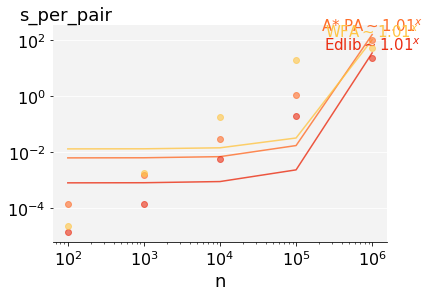

In [10]:
experiment_name = 'benchmark'

df = read_benchmarks('benchmarks/benchmark_1000000.tsv')

df['s_per_pair'] = df['s'] / df['cnt']
#df['logs_per_pair'] = np.log(df['s_per_pair'])
display(df)

df_n = df[df.e == 0.2]
df_e = df[df.n == 100000]
display(df_n)

# error rate
#plot_scaling(df_n, y='logs_per_pair', x='n', prefix=experiment_name, xlog=True, ylog=True)
#plot_scaling(df_e, y='logs_per_pair', x='e', prefix=experiment_name, xlog=True, ylog=True)

plot_scaling(df_n, y='s_per_pair', x='n', prefix=experiment_name, xlog=True, ylog=True)
plot_scaling(df_e, y='s_per_pair', x='e', prefix=experiment_name, xlog=True, ylog=True)
#plot_scaling(df, y='t(map)_per_bp', x='error_rate', hline=False, prefix=experiment_name)

In [ ]:
experiment_name = 'prefix_vs_seeds_ecoli_250_errors_intervals_cmp'
plots_dir = Path('plots')

df_seeds = read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-seeds/alignments.tsv')

df = read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-prefix/alignments.tsv')
df = df.append(df_seeds, ignore_index=True)
df = df.append(read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/dijkstra/alignments.tsv'), ignore_index=True)

#display(df_seeds.head())
#display(df.tail())
df_seeds.hist(column='cost')

#astar_vs_dijkstra_img(df_seeds, y='crumbs_per_bp', x='error_rate', hline=False, prefix=experiment_name)

# alignment cost
#astar_vs_dijkstra_img(df[df['cost']<=8], y='explored_per_bp', x='cost', hline=True, prefix=experiment_name)

#astar_vs_dijkstra_img(df[df['cost']<=8], y='explored_per_bp', x='cost', hline=True, prefix=experiment_name)
#astar_vs_dijkstra_img(df[df['cost']<=8], y='t(map)_per_bp', x='cost', hline=False, prefix=experiment_name)

# error rate
astar_vs_dijkstra_img(df,  y='explored_per_bp', x='error_rate', hline=True, prefix=experiment_name)
astar_vs_dijkstra_img(df, y='t(map)_per_bp', x='error_rate', hline=False, prefix=experiment_name)

NameError: name 'read_astarix_performance' is not defined

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,crumbs,pushed+popped,explored_per_bp,t(map)_per_bp,crumbs_per_bp,error_rate
readname,,,,,,,,,,,,,,,,,,,,,,,,
all-10000,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TACTAATCACAAAGTATTATGATACGGCAGTATGCTCGAACGCAGC...,tACtAATCACAAAGTaTTaTGATACGGCAGtATGcTCGAACGCAGC...,6,54749,+,1.632,0.192,0.0,0.008271,0.000311,1,643,0,1.824,2.572,0.000033,0.0,0.024
all-9999,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,CGCTGCTGTATCCGCTGGCGGAAGATGAGTTGATGAGCATCATTCT...,CGCTGCTgTATCCGCTGGCGGAAGAtGAGTTGATGAGCATCATTCT...,2,533486,+,0.848,0.088,0.0,0.010471,0.000208,1,450,0,0.936,1.800,0.000042,0.0,0.008
all-9998,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,GCTTCGCTTTGCCGTTAATAACATAGCTTGCAGTGGTCCGCGACAC...,GCTTCGCTTTGCCGTTAATAACATAGCTTGCAGTGGTCCGCGACAC...,1,87857,-,0.484,0.052,0.0,0.008959,0.000120,1,359,0,0.536,1.436,0.000036,0.0,0.004
all-9997,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TTATACCCAAGAGGGGTTAATGTTTGCCTCGATCGTTCAGGAAGGG...,TTATACCCAAGAgGGgtTAaTGtTTGCCTCGAtCGTTCAGGAAGGG...,6,474118,-,1.416,0.176,0.0,0.010818,0.000312,1,587,0,1.592,2.348,0.000043,0.0,0.024
all-9996,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TCCTAATTCACTTTCAGCAGGATTTTGCTGAACTCTTCAGTAGAGG...,TCCTaATTCACTTTCAGCAGGATTTTGCtGAACTCTTCAGTAGAGG...,2,483637,+,0.744,0.088,0.0,0.011031,0.000199,1,424,0,0.832,1.696,0.000044,0.0,0.008


/home/pesho/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pesho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
posx and posy should be finite values


crumbs_per_bp


posx and posy should be finite values
posx and posy should be finite values


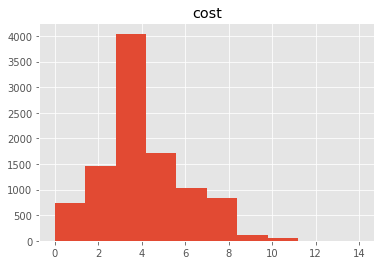

posx and posy should be finite values
posx and posy should be finite values


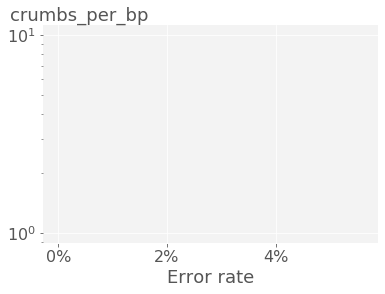

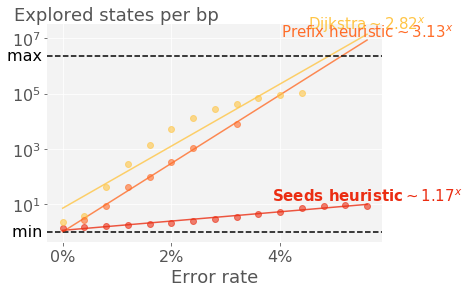

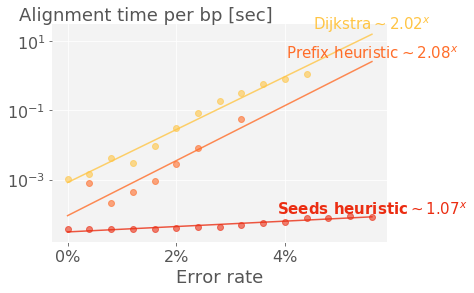

In [8]:
experiment_name = 'test'
plots_dir = Path('plots')

df_seeds = read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-seeds/alignments.tsv')

display(df_seeds.head())
#display(df.tail())
df_seeds.hist(column='cost')

astar_vs_dijkstra_img(df_seeds, y='crumbs_per_bp', x='error_rate', hline=False, prefix=experiment_name)

# error rate
astar_vs_dijkstra_img(df,  y='explored_per_bp', x='error_rate', hline=True, prefix=experiment_name)
astar_vs_dijkstra_img(df, y='t(map)_per_bp', x='error_rate', hline=False, prefix=experiment_name)

In [24]:
experiment_name = 'MHC'
plots_dir = Path('plots')
df = read_astarix_performance('results/MHC1-astarix-prefix/alignments.tsv')
#df = df.append(read_astarix_performance('results/MHC1-astarix-seeds/alignments.tsv'), ignore_index=True)
df = df.append(read_astarix_performance('results/MHC1-astarix-seeds-bfs/alignments.tsv'), ignore_index=True)

#df = read_astarix_performance('results/ecoli_illumina250_astar-seeds.tsv')
#df = df.append(read_astarix_performance('results/ecoli_illumina250_astar-prefix.tsv'), ignore_index=True)

#df.algo = df.algo.replace(regex=r'astar.*', value='astar')
reads = len(df)
df = df[df.cost <= 8.0]

#display(df.groupby('algo').mean())
display(df.head())
#display(df.groupby('cost').size() / reads)

KeyError: 'explored_states'

In [9]:
def draw_one(df, x, y, hline, prefix, is_log=True, show_mean=True):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F0F0F0')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    # spines
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['algo', x], group_keys=False)[y].mean()
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='algo', values='mean_{}'.format(y))

    z = {}
    for algo in d.columns:
        s = d[algo].dropna()
        ydata = np.log(s) if is_log else s
        z[algo] = np.polyfit(s.index, ydata, 1)
        
    xs = list(d.index)
    if show_mean:
        d = d.append(df.groupby('algo')[y].mean().rename('all'))
    xs.append(xs[-1]+0.8)  # extrapolation
        
    colors = [algo2color(algo) for algo in d.columns]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    if hline:
        ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 16}, framealpha=0.5)
    else:
        ax.legend(loc="upper left", prop={'size': 16}, framealpha=0.5)
    
    if hline:
        ax.axhline(df.refsize.median()*df.len.median(), color='k', linestyle='solid', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(max(df[x])+1.7, df.refsize.median()*df.len.median(), 'Theoretical\nMaximum', ha='left', va='center', size=16)
        
        ax.axhline(y=df.len.median(), color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(max(df[x])+1.7, df.len.median(), 'Theoretical\nminimum', ha='left', va='center', size=16)

    if is_log:
        ax.set_yscale('log')
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labels
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

In [10]:
#def run(experiment_name, tsv_file, plots_dir):
experiment_name = 'ecoli_clr_1000_2errors_nointervals'
plots_dir = Path('plots')
df = read_astarix_performance('results/' + experiment_name + '.tsv')
print(df.head())
#df = df.append(read_astarix_performance('tmp/ecoli_head1000000_linear_long_clr/astar-default/alignments.tsv'), ignore_index=True)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name)
draw_one(df, y='t(map)', x='cost', hline=False, prefix=experiment_name)

FileNotFoundError: [Errno 2] File results/ecoli_clr_1000_2errors_nointervals.tsv does not exist: 'results/ecoli_clr_1000_2errors_nointervals.tsv'

In [11]:
experiment_name = 'ecoli_ccs300'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_ccs_1000_0errors_intervals.tsv')
#df = df.append(read_astarix_performance('tmp/ecoli_head1000000_linear_long_clr/astar-default/alignments.tsv'), ignore_index=True)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, is_log=True)
draw_one(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, is_log=True)

FileNotFoundError: [Errno 2] File results/ecoli_ccs_1000_0errors_intervals.tsv does not exist: 'results/ecoli_ccs_1000_0errors_intervals.tsv'

In [12]:
experiment_name = 'ecoli_ccs_1000_0errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_ccs_1000_0errors_intervals.tsv')
df = df.append(read_astarix_performance('results/ecoli_ccs_1000_0errors_nointervals.tsv'), ignore_index=True)

print(df.head())
print(df.tail())

astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix='heuristic_'+experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals", show_mean=True)
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix='heuristic_'+experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals", show_mean=False)

FileNotFoundError: [Errno 2] File results/ecoli_ccs_1000_0errors_intervals.tsv does not exist: 'results/ecoli_ccs_1000_0errors_intervals.tsv'

In [13]:
experiment_name = 'ecoli_clr_1000_2errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_clr_1000_2errors_intervals.tsv')
df = df.append(read_astarix_performance('results/ecoli_clr_1000_2errors_nointervals.tsv'), ignore_index=True)

print(df.head())
print(df.tail())

astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals")
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals")

FileNotFoundError: [Errno 2] File results/ecoli_clr_1000_2errors_intervals.tsv does not exist: 'results/ecoli_clr_1000_2errors_intervals.tsv'

In [14]:
import seaborn as sns

def plot_states_per_kb(df):
    df['lenbin'] = (df['len'] // 150) * 150
    #df['explored_per_bp'] = df['explored_states'] / df['len']
    fig, axes = plt.subplots()
    bylen = df.groupby(by='lenbin')
    display(bylen.mean())
    p = bylen['explored_per_bp'].plot(figsize=(15,5),legend=False,kind="bar",rot=45,color="blue",fontsize=16) #,yerr=bylen.std());
    #ax = sns.violinplot(x="lenbin", y="explored_per_bp", data=df)
    #ax = df[['explored_per_bp', 'lenbin']].boxplot(by='lenbin', showfliers=False)
    #ax.set_yscale('log')

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,crumbs,pushed+popped,explored_per_bp,t(map)_per_bp,crumbs_per_bp,error_rate
readname,,,,,,,,,,,,,,,,,,,,,,,,
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,223,CGGTCATCGCGTCACATTCTGTACGGCAGGCATGGTGGCTATACGC...,CGGTCATCGCGTCACATTCTGTACGGCAGGCATGGTGGCTATACGC...,3,264827,+,0.753363,0.089686,0.0,0.001498,0.000144,1,233,3364,0.843049,1.044843,0.000007,15.085202,0.013453
S1_2,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,253,GGTTTCGTAGGCCGGATAAGGCGGTCACGCCGCATCCGGCATGAAC...,GGTTTCGTAGGCCGGATAAGGCGGTCACGCCGCATCCGGCATGAAC...,4,489752,-,0.533597,0.098814,0.0,0.001408,0.000138,1,264,4832,0.632411,1.043478,0.000006,19.098814,0.015810
S1_3,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,605,GGAGAAGTAATGTCGCGCGTCAATCCTCTATCTTCGCTGTGCATTG...,GGAGAAGTAATGTCGCGCGTCAATCCTCTATCTTCGCTGTgCATTG...,25,397868,+,8.523967,2.476033,0.0,0.051236,0.009456,1,2234,9148,11.000000,3.692562,0.000085,15.120661,0.041322
S1_4,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,395,TGATCGCCCGCTACCAGCGTATCGCTGGGCAAAAACGTCCTGCAGC...,TGATCGCCCGCTACCAGCGTATcGCTGGGCAAAAACGTCCTGCAGC...,10,674207,-,4.010127,0.756962,0.0,0.013853,0.002401,1,697,7435,4.767089,1.764557,0.000035,18.822785,0.025316
S1_5,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,235,CTTTCGGCAGCTATTCCTCCAGTGGGTGGCGTGATCATCGCCGACT...,CTTTCGGCAGCTATTCCTCCAGTGGGTGGCGTGATCATCGCCGACT...,2,355907,+,0.595745,0.076596,0.0,0.001451,0.000146,1,243,3734,0.672341,1.034043,0.000006,15.889362,0.008511


,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,crumbs,pushed+popped,explored_per_bp,t(map)_per_bp,crumbs_per_bp,error_rate
readname,,,,,,,,,,,,,,,,,,,,,,,,
S1_2182,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,245,ATCTTCGTTGATAGATTTACTTCACCAGCTGTTACATTAAGATAAT...,ATCTTCGTTGATAGATTTACTTCACCAGCTGTTACATTAAGATAAT...,4,262795,-,0.657143,0.106122,0.0,0.001634,0.000177,1,264,5436,0.763265,1.077551,0.000007,22.187755,0.016327
S1_2183,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,854,TTATTTATTCGCTGTAAAAGGAAACCAGGGGCGGCTAATAAAGCCT...,ttATTTATTCGCTGTAAAAGGAAACCAGGGGCGGCTAATAAAGCCT...,16,737408,+,4.885246,1.040984,0.0,0.056184,0.023877,1,1779,42420,5.926230,2.083138,0.000066,49.672131,0.018735
S1_2184,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,477,GTCAGTTTCAAACCGATCTCATCATCGATAACATGTTTTGCACCAA...,GTCAGTTTCAAACCGATCTCATCATCGATAACATGTTTTGCACCAA...,14,660418,-,9.234801,2.203354,0.0,0.042292,0.008047,1,1596,9329,11.438155,3.345912,0.000089,19.557652,0.029350
S1_2185,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,500,ACGCTGGCGATACCACGGCACTCGTCCCTTTTAGCCTGCGGCTGGA...,ACGCTGGCGATACCACGGCACTCGTCCCTTTTAGCCTGCGGCTGGA...,9,563527,+,0.656000,0.094000,0.0,0.003660,0.000500,1,542,10617,0.750000,1.084000,0.000007,21.234000,0.018000
S1_2186,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,100,GTATCAATACCGGGGTATTTTGACACCCTGTCAGTAATGCTGCAGA...,GTATCAATACCGGGGTATTTTGACACCCTGTCAGTAATGCTGCAGA...,3,960246,-,1.360000,0.290000,0.0,0.001532,0.000082,1,125,948,1.650000,1.250000,0.000015,9.480000,0.030000


,refsize,memory,len,cost,start,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,crumbs,pushed+popped,explored_per_bp,t(map)_per_bp,crumbs_per_bp,error_rate
lenbin,,,,,,,,,,,,,,,,,,
0,2298534.0,0.0,136.857143,2.428571,572821.571429,1.587628,0.267106,0.0,0.001939,0.000159,1.000000,163.285714,1684.571429,1.854734,1.201441,0.000015,12.177503,0.018449
150,2298534.0,0.0,252.336788,4.725389,509410.715026,2.064662,0.373616,0.0,0.004502,0.000493,0.919689,345.147668,4090.715026,2.438278,1.377699,0.000018,16.124565,0.018736
300,2298534.0,0.0,375.222591,7.014396,481532.931340,2.030786,0.402462,0.0,0.007232,0.001128,0.946844,530.439646,7367.222591,2.433248,1.410286,0.000019,19.477648,0.018680
450,2298534.0,0.0,514.980132,9.683775,501474.225166,2.514759,0.551980,0.0,0.013433,0.002873,0.955298,832.875828,12572.447020,3.066739,1.610437,0.000026,24.300975,0.018809
600,2298534.0,0.0,660.137500,12.400000,501039.229167,2.979328,0.661953,0.0,0.022292,0.006334,0.954167,1160.725000,18746.629167,3.641281,1.751500,0.000034,28.313979,0.018740
750,2298534.0,0.0,818.215190,16.430380,511484.329114,3.838867,0.884250,0.0,0.040790,0.014989,0.848101,1762.987342,24934.037975,4.723116,2.139368,0.000049,30.450393,0.019958
900,2298534.0,0.0,957.903226,18.870968,565151.129032,3.081094,0.824059,0.0,0.046231,0.020561,1.000000,1932.032258,32979.516129,3.905153,2.019440,0.000048,34.369878,0.019696
1050,2298534.0,0.0,1123.375000,21.125000,341892.375000,4.248943,0.940041,0.0,0.080977,0.041642,1.000000,2520.375000,49282.125000,5.188983,2.239238,0.000072,43.946223,0.018810
1200,2298534.0,0.0,1319.250000,33.250000,508885.500000,5.626988,1.832430,0.0,0.155520,0.089867,0.500000,4274.750000,57178.750000,7.459418,3.245804,0.000118,43.313866,0.025230


TypeError: expected non-empty vector for x

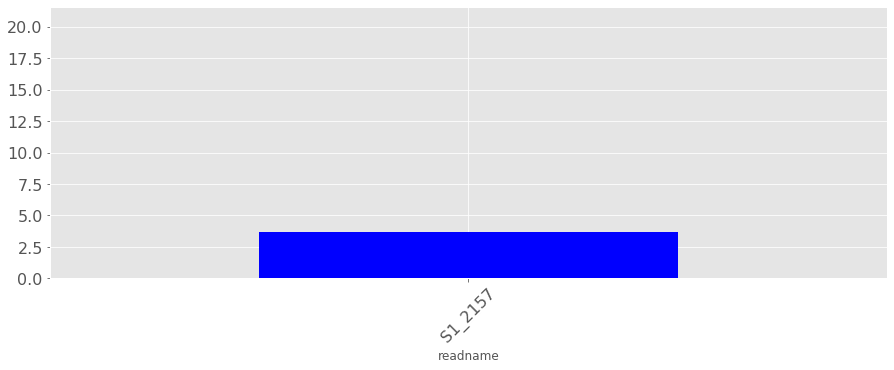

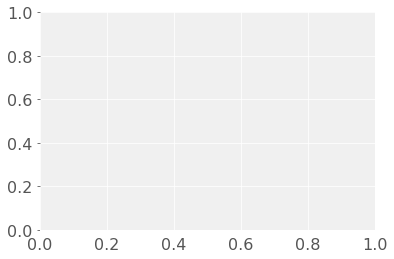

In [15]:
experiment_name = 'seeds_length_scaling_ccs'
plots_dir = Path('plots')
df = read_astarix_performance('../tmp/ecoli_head1000000_linear_ccs/astar-seeds/alignments.tsv')

display(df.head())
display(df.tail())

plot_states_per_kb(df)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, is_log=True)
draw_one(df, y='explored_states', x='len', hline=True, prefix=experiment_name, is_log=True)

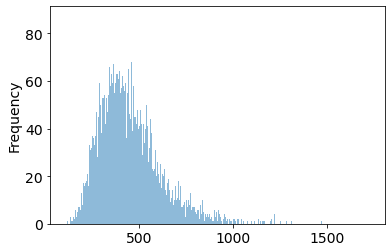

In [12]:
ax = df['len'].plot.hist(bins=max(df['len'])-min(df['len'])+1, alpha=0.5)

<AxesSubplot:xlabel='len', ylabel='explored_states'>

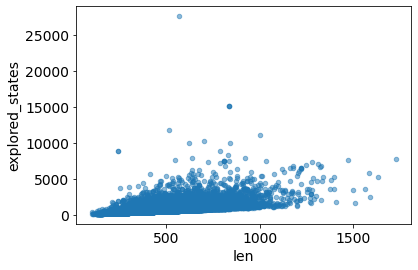

In [13]:
df.plot.scatter(x='len', y='explored_states', alpha=0.5)

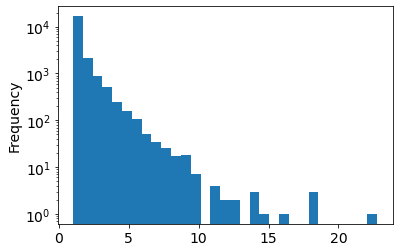

In [14]:
ax = df.loc[df['explored_per_bp'] < 30]['explored_per_bp'].plot.hist(bins=31)
ax.set_yscale('log')

In [16]:
df.loc[df['explored_per_bp'] < 1.0]

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,lenbin,explored_per_bp
readname,,,,,,,,,,,,,,,,,,,,,


,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,crumbs,pushed+popped,explored_per_bp,t(map)_per_bp,crumbs_per_bp,error_rate
0,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,14998,CAGTAATATCATTAATAATTATTTGTGCGCCATATTTACCCAGGCC...,CAGTAATATCATTAATAATTATTTGTGCGCCATATTTACCCAGGCC...,48,4493229,+,7.471330,1.336378,0.0,67.142232,7.317810,1,127224,0,8.807708,8.482731,0.004477,0.0,0.003200
1,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,14988,AGAAAATCCGCAGCAAGCTCATTCAGTCACTGATCTACCCCTGTAT...,AGAAAATCCGCAGCAAGCTCATTCAGTCACTGATCTACCCCTGTAT...,51,3460291,+,22.606752,4.023752,0.0,56.921632,10.864010,1,354621,0,26.630504,23.660328,0.003798,0.0,0.003403
2,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,14998,GCACCTTATGCGCGCGTGCCCCCAGTTTCAGCGCCAGTTCGCGTGC...,GCACCTTATGCGCGCGTGCCCCCAGTTTCAGCGCCAGTTCGCGTGC...,39,465371,+,28.270903,4.502867,0.0,70.770828,17.366705,1,439817,0,32.773770,29.325043,0.004719,0.0,0.002600
3,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,15005,TCATATTCTTCTCCCGAAAAAAAACAGGGCTTGCGCCCTGTTTCTG...,TCATATTCTTCTCCCGAAAAAAAACAGGGCTTGCGCCCTGTTTCTG...,56,1089967,-,7.448517,1.405731,0.0,49.347440,7.184021,1,127132,0,8.854248,8.472642,0.003289,0.0,0.003732
4,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,14991,GACCACGGTCGAAAATGACCTCTCGCTTGCTTAATGGAATACCGGG...,GACCACGGTCGAAAATGACCTCTCGCTTGCTTAATGGAATACCGGG...,41,1188491,+,1.616703,0.293576,0.0,43.333923,4.538016,1,39258,0,1.910279,2.618771,0.002891,0.0,0.002735
5,prefixes/ecoli_head10000000.fa,10610303,astar-seeds,align,0.0,15003,GGCCTGTTTCGCGGCGGCACGGGCTTTTTCTACCGTGGCATTAACC...,GGCCTGTTTCGCGGCGGCACGGGCTTTTTCTACCGTGGCATTAACC...,47,4303710,+,6.626075,1.153436,0.0,64.361060,11.546722,1,114509,0,7.779511,7.632407,0.004290,0.0,0.003133
6,prefixes/ecoli_head10000000.fa,10610303,astarix-seeds_wo_match_pos,align,0.0,14998,CAGTAATATCATTAATAATTATTTGTGCGCCATATTTACCCAGGCC...,CAGTAATATCATTAATAATTATTTGTGCGCCATATTTACCCAGGCC...,48,4493229,+,62.346846,15.722030,0.0,74.309457,21.064663,1,950252,0,78.068876,63.358581,0.004955,0.0,0.003200
7,prefixes/ecoli_head10000000.fa,10610303,astarix-seeds_wo_match_pos,align,0.0,14988,AGAAAATCCGCAGCAAGCTCATTCAGTCACTGATCTACCCCTGTAT...,AGAAAATCCGCAGCAAGCTCATTCAGTCACTGATCTACCCCTGTAT...,51,3460291,+,72.784361,17.515612,0.0,72.986402,22.109393,1,1106639,0,90.299973,73.835001,0.004870,0.0,0.003403
8,prefixes/ecoli_head10000000.fa,10610303,astarix-seeds_wo_match_pos,align,0.0,14998,GCACCTTATGCGCGCGTGCCCCCAGTTTCAGCGCCAGTTCGCGTGC...,GCACCTTATGCGCGCGTGCCCCCAGTTTCAGCGCCAGTTCGCGTGC...,39,465371,+,67.254634,14.043472,0.0,77.024273,19.376200,1,1024401,0,81.298106,68.302507,0.005136,0.0,0.002600
9,prefixes/ecoli_head10000000.fa,10610303,astarix-seeds_wo_match_pos,align,0.0,15005,TCATATTCTTCTCCCGAAAAAAAACAGGGCTTGCGCCCTGTTTCTG...,TCATATTCTTCTCCCGAAAAAAAACAGGGCTTGCGCCCTGTTTCTG...,56,1089967,-,72.259114,18.783339,0.0,77.892322,24.726411,1,1099608,0,91.042453,73.282772,0.005191,0.0,0.003732


astarix-seeds_wo_match_pos


AssertionError: 

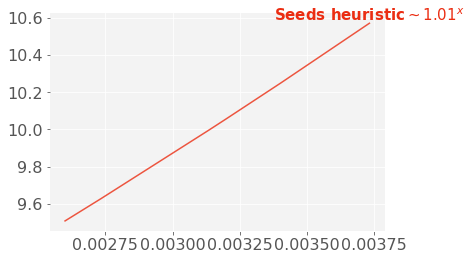

In [16]:
experiment_name = 'ablation'
plots_dir = Path('plots')

df = read_astarix_performance('results_ablation/astarix-seeds/ecoli_head10000000_N200_m15000_hifi/out/alignments.tsv')
df = df.append(read_astarix_performance('results_ablation/astarix-seeds_wo_match_pos/ecoli_head10000000_N200_m15000_hifi/out/alignments.tsv', algo='astarix-seeds_wo_match_pos'), ignore_index=True)
df = df.append(read_astarix_performance('results_ablation/astarix-seeds_wo_skip_near_crumbs_pos/ecoli_head10000000_N200_m15000_hifi/out/alignments.tsv', algo='astarix-seeds_wo_skip_near_crumbs_pos'), ignore_index=True)

display(df)

# error rate
astar_vs_dijkstra_img(df,  y='explored_per_bp', x='error_rate', hline=False, ylog=False, prefix=experiment_name)
astar_vs_dijkstra_img(df, y='t(map)_per_bp', x='error_rate', hline=False, ylog=False, prefix=experiment_name)

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,crumbs,pushed+popped,explored_per_bp,t(map)_per_bp,crumbs_per_bp,error_rate
readname,,,,,,,,,,,,,,,,,,,,,,,,
Created-100000,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,GCCGGAGTAATAGTTTGCGGGCAAGGGGATGTTGGAGAGCACACAC...,GCCGGAGTAATaGTTTgCGGGCAAGgGGATGTTGGAGAGCACACAC...,3,638157,-,0.950,0.130,0.0,0.037359,0.0,1,373,0,1.080,1.865,0.000187,0.0,0.015
Created-99999,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,CATCTTGTTGAATTGATCCCTTTAACAATATATATTGGCCTTCTTT...,CaTCTTGTTGAATTGATCCCTTTAaCAaTATaTAtTGGCCTTCTTT...,5,4141791,-,3.210,0.400,0.0,0.002111,0.0,1,830,0,3.610,4.150,0.000011,0.0,0.025
Created-99998,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,CCCTTCATTTGACCATGACTGACAGTTTAAATTGCTCTAGGTATAG...,CcCTTCATTTGACcATGACTGaCAGTTTAAATTGCTCTAGGTATAG...,3,3695730,-,2.915,0.355,0.0,0.000933,0.0,1,763,0,3.270,3.815,0.000005,0.0,0.015
Created-99997,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,ATGATATACACGAAAGTGTATAGGGAAACGCAAAGCAATCTGAATA...,ATgATATACAcGAAAGtgtATaGGGAAAcGcAAAGCAATCTGAATA...,8,3790574,+,9.115,1.315,0.0,0.001360,0.0,1,1998,0,10.430,9.990,0.000007,0.0,0.040
Created-99996,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,CTGCACACAACCTGAGGAGAGTAGGAAGAGCACTGGATTTAAAGCC...,CTGcAcACAACCTgAGGAGAGTAGGAAGAGCACTGGATTTAAAGCC...,4,2760824,-,3.375,0.415,0.0,0.001543,0.0,1,851,0,3.790,4.255,0.000008,0.0,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Created-5,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,ATAAAAGTGTCTCCATCACTAATAATCAGGGAAGTGCAAATTAAAA...,AtAAAAGTGTCTcCATCACTAATaATCAGGGAAgTGCAAATTAAAA...,4,3747804,+,2.500,0.315,0.0,0.000999,0.0,1,680,0,2.815,3.400,0.000005,0.0,0.020
Created-4,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,AATATCTATTTCAACGTCCGGATTGTGATGTTGTGCTATAGTTTTG...,AATATCtATtTCAAcgTCCGGATTGTGATgTTGTGCTATAGTTTTG...,5,3567907,+,3.555,0.465,0.0,0.002339,0.0,1,887,0,4.020,4.435,0.000012,0.0,0.025
Created-3,graphs/MHC1_head0.gfa,28026998,astar-seeds,align,0.0,200,AGCCAATGAGCTTAAACTAGTTCGGGGCGCTCTCATTTTCCCAATT...,AGCCAAtgAGctTAAACTagTTcGGGGcGCTCTCATTTTCCCAATT...,8,3670380,+,12.620,1.935,0.0,0.002516,0.0,1,2700,0,14.555,13.500,0.000013,0.0,0.040


t(map)_per_bp
0.000002    0.000002
0.000002    0.000002
0.000002    0.000002
0.000002    0.000002
0.000002    0.000002
              ...   
0.008103    0.008103
0.008831    0.008831
0.010557    0.010557
0.014292    0.014292
0.037958    0.037958
Name: t(map)_per_bp, Length: 14675, dtype: float64
t(map)_per_bp
0.000002    0.000002
0.000002    0.000002
0.000002    0.000002
0.000002    0.000002
0.000002    0.000002
              ...   
0.000617    0.000617
0.000622    0.000622
0.000671    0.000671
0.000701    0.000701
0.000773    0.000773
Name: t(map)_per_bp, Length: 3317, dtype: float64
t(map)_per_bp
0.000002    0.000002
0.000002    0.000002
0.000003    0.000003
0.000003    0.000003
0.000003    0.000003
              ...   
0.000395    0.000395
0.000403    0.000403
0.000408    0.000408
0.000671    0.000671
0.000877    0.000877
Name: t(map)_per_bp, Length: 805, dtype: float64


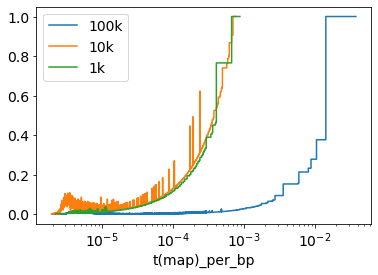

In [199]:
df100k = read_astarix_performance('results_FULLEST_1027/astarix-seeds-illumina/MHC1_head0_N100000_m200_illumina_errors-1_seedlen25/out/alignments.tsv')
df10k = read_astarix_performance('results_FULLEST_1027/astarix-seeds-illumina/MHC1_head0_N10000_m200_illumina_errors-1_seedlen25/out/alignments.tsv')
df1k = read_astarix_performance('results_FULLEST_1027/astarix-seeds-illumina/MHC1_head0_N1000_m200_illumina_errors-1_seedlen25/out/alignments.tsv')
display(df100k)

#df_seeds.cost.hist()
fig, ax = plt.subplots(nrows=1, ncols=1)
for df, label in [(df100k, '100k'), (df10k, '10k'), (df1k, '1k')]:
    y = df.groupby('t(map)_per_bp')['t(map)_per_bp'].sum()#.cumsum()
    print(y)
    z = y/y.max()
    z.rename(label, inplace=True)
    z.plot.line(z, legend=True, ax=ax, drawstyle='steps')
    ax.set_xscale('log')

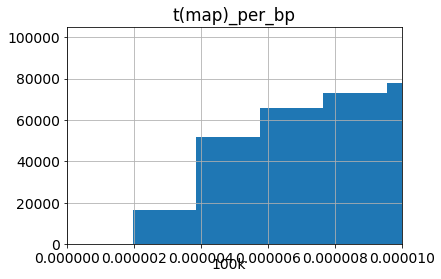

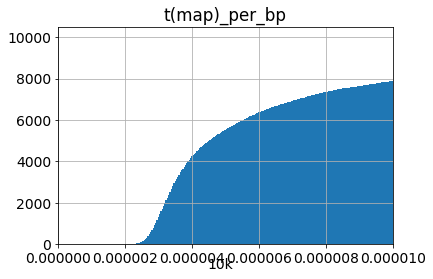

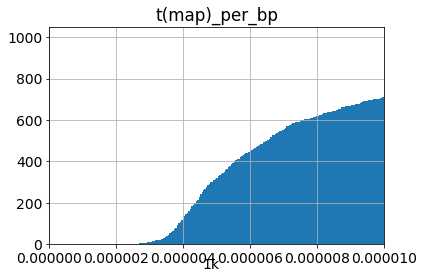

In [217]:
#import numpy as np
#import seaborn as sns
#fig = plt.figure()
#ax = fig.add_subplot(111)
#x = np.random.randn(200)
#kwargs = {'cumulative': True}

for df, label in [(df100k, '100k'), (df10k, '10k'), (df1k, '1k')]:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    df.hist(column='t(map)_per_bp', ax=ax, bins=20000, log=False, cumulative=True)
    ax.set_xlim((0.0, 0.00001))
    ax.set_ylim(bottom=0.0)
    fig.text(0.5, 0.04, label, ha='center')
    #sns.distplot(df['t(map)_per_bp'], hist_kws=kwargs, kde_kws=kwargs)    

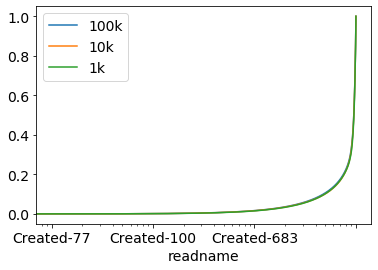

In [215]:
for df, label, step in [(df100k, '100k', 100), (df10k, '10k', 10), (df1k, '1k', 1)]:
    s = df['t(map)_per_bp'].sort_values().cumsum()
    s = s[::step]
    s = s/s.max()
    s.rename(label, inplace=True)
    s.plot(logx=True, legend=True)

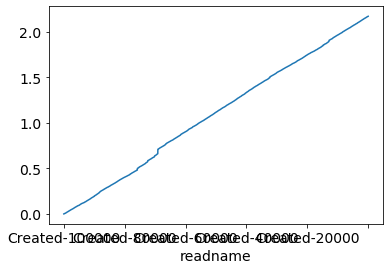

In [254]:
b = df100k['t(map)_per_bp']
#print(b.rolling(2000))
#a = df100k['logt'].rolling(200).ave()
b.cumsum().plot()
a=b.ewm(span = 400).mean()
#a=b[::300]
#a.plot()
#np.log(a).plot()


In [13]:
import seaborn as sns
penguins = sns.load_dataset("penguins")
sns.ecdfplot(data=penguins, x="flipper_length_mm")

AttributeError: module 'seaborn' has no attribute 'ecdfplot'